# Smart Analysis

API :: [opstool.anlys.SmartAnalyze](https://opstool.readthedocs.io/en/latest/src/api/_autosummary/opstool.anlys.SmartAnalyze.html#opstool.anlys.SmartAnalyze)

In [1]:
import openseespy.opensees as ops

import opstool as opst

## Reinforced Concrete Frame Pushover Analysis

### Moddling

In [2]:
def model():
    ops.wipe()
    ops.model("basic", "-ndm", 3, "-ndf", 6)
    width = 360.0
    height = 144.0
    ops.node(1, 0.0, 0.0, 0.0)
    ops.node(2, width, 0.0, 0.0)
    ops.node(3, 0.0, 0.0, height)
    ops.node(4, width, 0.0, height)
    ops.fix(1, 1, 1, 1, 1, 1, 1)
    ops.fix(2, 1, 1, 1, 1, 1, 1)

    ops.uniaxialMaterial("Concrete01", 1, -6.0, -0.004, -5.0, -0.014)
    ops.uniaxialMaterial("Concrete01", 2, -5.0, -0.002, 0.0, -0.006)

    fy = 60.0
    E = 30000.0
    ops.uniaxialMaterial("Steel01", 3, fy, E, 0.01)

    # Define cross-section for nonlinear columns
    # ------------------------------------------
    colWidth = 15
    colDepth = 24
    cover = 1.5
    As = 0.60  # area of no. 7 bars
    # some variables derived from the parameters
    y1 = colDepth / 2.0
    z1 = colWidth / 2.0

    ops.section("Fiber", 1, "-GJ", 1000000)
    ops.patch("rect", 1, 10, 10, cover - y1, cover - z1, y1 - cover, z1 - cover)
    # Create the concrete cover fibers (top, bottom, left, right)
    ops.patch("rect", 2, 11, 1, -y1, z1 - cover, y1, z1)
    ops.patch("rect", 2, 11, 1, -y1, -z1, y1, cover - z1)
    ops.patch("rect", 2, 1, 10, -y1, cover - z1, cover - y1, z1 - cover)
    ops.patch("rect", 2, 1, 10, y1 - cover, cover - z1, y1, z1 - cover)
    # Create the reinforcing fibers (left, middle, right)
    ops.layer("straight", 3, 5, As, y1 - cover, z1 - cover, y1 - cover, cover - z1)
    ops.layer("straight", 3, 2, As, 0.0, z1 - cover, 0.0, cover - z1)
    ops.layer("straight", 3, 5, As, cover - y1, z1 - cover, cover - y1, cover - z1)

    # Define column elements
    # ----------------------
    ops.geomTransf("PDelta", 1, -1, 0, 0)
    # Number of integration points along length of element
    np = 5
    # Lobatto integratoin
    ops.beamIntegration("Lobatto", 1, 1, np)
    eleType = "forceBeamColumn"
    ops.element(eleType, 1, 1, 3, 1, 1)
    ops.element(eleType, 2, 2, 4, 1, 1)

    # Define beam elment
    # -----------------------------
    ops.geomTransf("Linear", 2, 0.0, 0.0, 1.0)
    ops.element("elasticBeamColumn", 3, 3, 4, 360.0, 4030.0, 2015.0, 10000, 8640.0, 8640.0, 2)

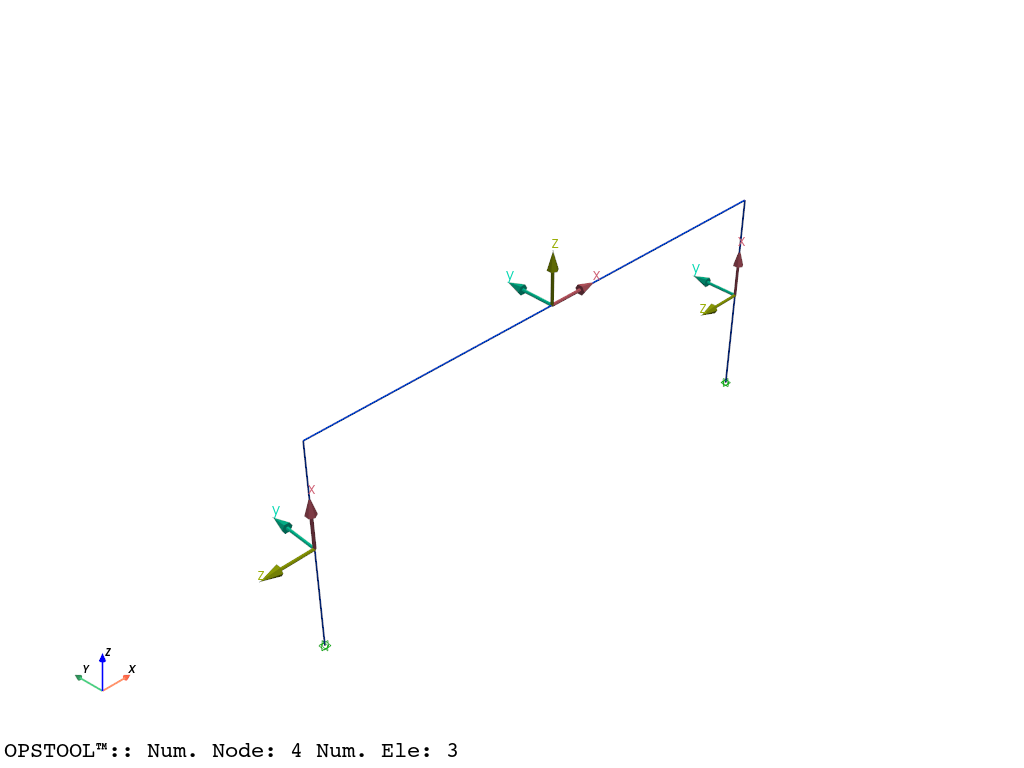

In [3]:
model()
opst.vis.pyvista.set_plot_props(notebook=True)  # you should not use
fig = opst.vis.pyvista.plot_model(show_local_axes=True)
fig.show(jupyter_backend="jupyterlab")
# fig.show()

### Gravity analysis

In [4]:
def gravity_analysis():
    #  a parameter for the axial load
    P = 180.0  # 10% of axial capacity of columns

    # Create a Plain load pattern with a Linear TimeSeries
    ops.timeSeries("Linear", 1)
    ops.pattern("Plain", 1, 1)

    # Create nodal loads at nodes 3 & 4
    #    nd  FX,  FY, MZ
    ops.load(3, 0.0, 0.0, -P, 0.0, 0.0, 0.0)
    ops.load(4, 0.0, 0.0, -P, 0.0, 0.0, 0.0)

    # Start of analysis generation
    # ------------------------------
    ops.system("BandGeneral")
    ops.constraints("Transformation")
    ops.numberer("RCM")
    ops.test("NormDispIncr", 1.0e-12, 10, 3)
    ops.algorithm("Newton")
    ops.integrator("LoadControl", 0.1)
    ops.analysis("Static")
    ops.analyze(10)

### Pushover analysis

In [5]:
def pushover_load():
    ops.loadConst("-time", 0.0)
    # Define lateral loads
    # --------------------
    # Set some parameters
    H = 10.0  # Reference lateral load
    # Set lateral load pattern with a Linear TimeSeries
    ops.pattern("Plain", 2, 1)
    ops.load(3, H, 0.0, 0.0, 0.0, 0.0, 0.0)
    ops.load(4, H, 0.0, 0.0, 0.0, 0.0, 0.0)

### Smart Analysis

#### No fixed number of analyses

In [6]:
# Set some parameters
dU = 0.1  # Displacement increment
maxU = 45.0  # Max displacement
ok = 0
currentDisp = 0

model()
gravity_analysis()
pushover_load()

If ``tryAddTestTimes`` is turned on, it will first try to increase the number of test; 

if ``tryAlterAlgoTypes`` is turned on, it will continue to try to change the iterative algorithm specified by the user; 

Then, if it does not converge, it will try to automatically split the step size until the specified minimum step size ``minStep`` is reached. 

If it still does not converge, the analysis is considered to have failed.

We can see that opensees throws out non-convergence information, but converges successfully when the number of iterations increases to 50.

In [7]:
ODB = opst.post.CreateODB(odb_tag=1)  # Create an ODB object to store results

analysis = opst.anlys.SmartAnalyze(
    "Static",
    tryAddTestTimes=True,  # add test times to the analysis
    testIterTimesMore=[50, 100],
    tryAlterAlgoTypes=True,  # try different algorithms
    algoTypes=[40, 10, 20, 30],  # algorithm types to try
    minStep=1e-6,  # minimum step size for substepping
    debugMode=True,  # False for progress bar, True for debug info
    printPer=100,  # print every 100 steps
)

while ok == 0 and currentDisp < maxU:
    #  Perform the analysis one step at a time
    analysis.StaticAnalyze(node=3, dof=1, seg=dU)

    ODB.fetch_response_step()  # Fetch the response for the current step

    currentDisp = ops.nodeDisp(3, 1)

analysis.close()  # Close the analysis object, when analysis steps are unknown

ODB.save_response()

print("🎉 Analysis Completed Successfully 🎉")

>>> ✳️ OPSTOOL::SmartAnalyze:: Setting algorithm to KrylovNewton ...
>>> ✅ OPSTOOL::SmartAnalyze:: progress 100 steps. Time consumption: 0.051 s.
>>> ✅ OPSTOOL::SmartAnalyze:: progress 200 steps. Time consumption: 0.099 s.
>>> ✳️ OPSTOOL::SmartAnalyze:: Adding test times to 50.
>>> ✅ OPSTOOL::SmartAnalyze:: progress 300 steps. Time consumption: 0.143 s.
>>> ✅ OPSTOOL::SmartAnalyze:: progress 400 steps. Time consumption: 0.201 s.


after: 10 iterations
 current EnergyIncr: 1.84355e-05 (max: 1e-10) 	Norm deltaX: 0.000384464, Norm deltaR: 0.194756
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 2.89482
OpenSees > analyze failed, returned: -3 error flag
after: 10 iterations
 current EnergyIncr: 2.70125e-05 (max: 1e-10) 	Norm deltaX: 0.000819596, Norm deltaR: 0.253889
AcceleratedNewton::solveCurrentStep() -The ConvergenceTest object failed in test()
StaticAnalysis::analyze() - the Algorithm failed at step: 0 with domain at load factor 1.64367
OpenSees > analyze failed, returned: -3 error flag


>>> ✳️ OPSTOOL::SmartAnalyze:: Adding test times to 50.


OPSTOOL™ ::  All responses data with _odb_tag = 1 saved in 
g:\opstool\docs\src\analysis\.opstool.output\RespStepData-1.odb!

🎉 Analysis Completed Successfully 🎉


#### Analysis of the fixed number of steps

In [8]:
# Set some parameters
dU = 0.1  # Displacement increment
maxU = 45.0  # Max displacement

model()
gravity_analysis()
pushover_load()

In [9]:
ODB = opst.post.CreateODB(odb_tag=2)  # Create ODB object

analysis = opst.anlys.SmartAnalyze(
    "Static",
    tryAddTestTimes=True,  # add test times to the analysis
    testIterTimesMore=[50, 100],
    tryAlterAlgoTypes=True,  # try different algorithms
    algoTypes=[40, 10, 20, 30],  # algorithm types to try
    minStep=1e-6,  # minimum step size for substepping
    relaxation=0.5,
    debugMode=False,  # False for progress bar, True for debug info
)
segs = analysis.static_split([maxU], dU)  # Tell the analysis how to split the steps, and how many steps to take

for seg in segs:
    analysis.StaticAnalyze(node=3, dof=1, seg=seg)
    ODB.fetch_response_step()  # fetch response for the current step
ODB.save_response()  # save response to ODB
analysis.close()  # Close the analysis object

🚀 OPSTOOL::SmartAnalyze: 100%|██████████| 450/450 [00:00<00:00, 1138.52 step/s]


Note: OpenSees LogFile has been generated in .SmartAnalyze-OpenSees.log.
>>> 🎉 OPSTOOL::SmartAnalyze:: Successfully finished! Time consumption: 0.397 s. 🎉


OPSTOOL™ ::  All responses data with _odb_tag = 2 saved in 
g:\opstool\docs\src\analysis\.opstool.output\RespStepData-2.odb!

### Post-processing

#### Nodal Responses

In [10]:
node_resp = opst.post.get_nodal_responses(odb_tag=1)
print(node_resp)

OPSTOOL™ ::  Loading all response data from g:\opstool\docs\src\analysis\.opstool.output\RespStepData-1.odb ...

<xarray.DatasetView> Size: 269kB
Dimensions:             (time: 451, nodeTags: 4, DOFs: 6)
Coordinates:
  * time                (time) float32 2kB 0.0 0.6715 1.179 ... 1.536 1.519
  * nodeTags            (nodeTags) int64 32B 1 2 3 4
  * DOFs                (DOFs) <U2 48B 'UX' 'UY' 'UZ' 'RX' 'RY' 'RZ'
Data variables:
    accel               (time, nodeTags, DOFs) float32 43kB 0.0 0.0 ... 0.0 0.0
    disp                (time, nodeTags, DOFs) float32 43kB 0.0 ... 6.499e-15
    pressure            (time, nodeTags) float32 7kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    rayleighForces      (time, nodeTags, DOFs) float32 43kB 0.0 0.0 ... 0.0 0.0
    reaction            (time, nodeTags, DOFs) float32 43kB 1.08e-15 ... -4.9...
    reactionIncInertia  (time, nodeTags, DOFs) float32 43kB 1.08e-15 ... -4.9...
    vel                 (time, nodeTags, DOFs) float32 43kB 0.0 0.0 ... 0.0 0.0
Attributes:
    UX:       Displacement in X direction
    UY:       Displacement in Y direction
    UZ:       Displacemen

In [11]:
node3disp = node_resp["disp"].sel(nodeTags=3, DOFs="UX")
reaction = node_resp["reaction"].sel(DOFs="UX").sum(dim="nodeTags")

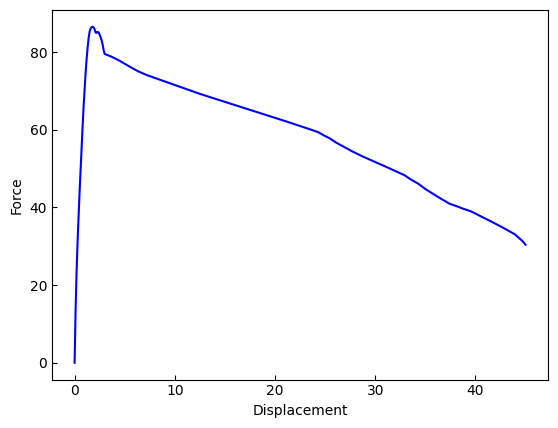

In [12]:
import matplotlib.pyplot as plt

plt.plot(node3disp, -reaction, c="b")
plt.xlabel("Displacement")
plt.ylabel("Force")
plt.show()

#### Frame Element Responses

In [13]:
frame_resp = opst.post.get_element_responses(odb_tag=1, ele_type="Frame")
frame_resp

OPSTOOL™ ::  Loading Frame response data from g:\opstool\docs\src\analysis\.opstool.output\RespStepData-1.odb ...

<xarray.DatasetView> Size: 771kB
Dimensions:              (time: 451, eleTags: 3, basicDofs: 6, localDofs: 12,
                          secPoints: 7, secDofs: 6, locs: 4)
Coordinates:
  * time                 (time) float32 2kB 0.0 0.6715 1.179 ... 1.536 1.519
  * eleTags              (eleTags) int64 24B 1 2 3
  * basicDofs            (basicDofs) <U3 72B 'N' 'MZ1' 'MZ2' 'MY1' 'MY2' 'T'
  * localDofs            (localDofs) <U3 144B 'FX1' 'FY1' 'FZ1' ... 'MY2' 'MZ2'
  * secPoints            (secPoints) int64 56B 1 2 3 4 5 6 7
  * secDofs              (secDofs) <U2 48B 'N' 'MZ' 'VY' 'MY' 'VZ' 'T'
  * locs                 (locs) <U5 80B 'alpha' 'X' 'Y' 'Z'
Data variables:
    basicDeformations    (time, eleTags, basicDofs) float32 32kB -0.01746 ......
    basicForces          (time, eleTags, basicDofs) float32 32kB -180.0 ... 4...
    localForces          (time, eleTags, localDofs) float32 65kB -180.0 ... -...
    plasticDeformation   (time, eleTags, basicDofs) float32 32kB -0.0003215 ....
    sectionDeformations  (time, eleTags, secPoints, secDofs) float32 227kB -0...
    sectionForces        (time, eleTags, secPoints, secDofs) float32 227kB -1...
    sectionLocs          (time, eleTags, secPoints, locs) float32 152kB 0.0 ....
Attributes:
    localDofs:  local coord system dofs at end 1 and end 2
    basicDofs:  basic coord system dofs at end 1 and end 2
    secPoints:  section points No.
    secDofs:    section forces and deformations Dofs. Note that the section D...
    Notes:      Note that the deformations are displacements and rotations in...

In [14]:
frame1defo = frame_resp["sectionDeformations"].sel(eleTags=1, secDofs="MY")
frame1fo = frame_resp["sectionForces"].sel(eleTags=1, secDofs="MY")
frame1defo = frame1defo.dropna(dim="secPoints", how="all")
frame1fo = frame1fo.dropna(dim="secPoints", how="all")
frame1defo.head()

<xarray.DataArray 'sectionDeformations' (time: 5, secPoints: 5)> Size: 100B
array([[-2.5559136e-21, -1.4624082e-21, -1.5771168e-22,  2.1066618e-22,
         6.5240725e-22],
       [ 2.1244745e-05,  1.4625922e-05,  4.2289248e-06, -6.0741395e-06,
        -1.1554748e-05],
       [ 5.3475043e-05,  2.8809924e-05,  5.9333643e-06, -1.2168541e-05,
        -2.4224235e-05],
       [ 8.3909654e-05,  4.4445082e-05,  6.2719751e-06, -1.8140119e-05,
        -4.4766162e-05],
       [ 1.1238557e-04,  6.0898597e-05,  6.6196931e-06, -2.5983645e-05,
        -6.7724483e-05]], dtype=float32)
Coordinates:
  * time       (time) float32 20B 0.0 0.6715 1.179 1.568 1.901
  * secPoints  (secPoints) int64 40B 1 2 3 4 5
    eleTags    int64 8B 1
    secDofs    <U2 8B 'MY'

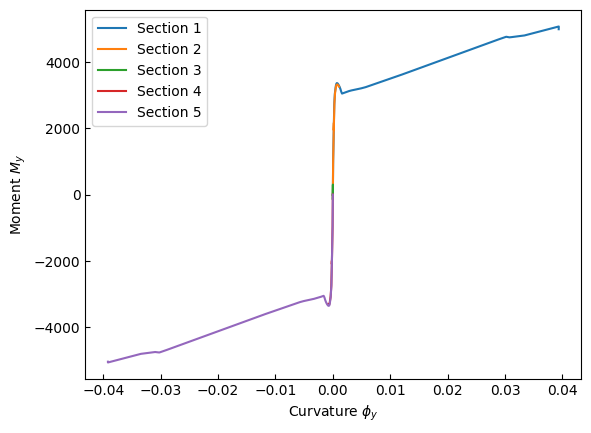

In [15]:
for sec in frame1defo.secPoints.data:
    x = frame1defo.sel(secPoints=sec).data
    y = frame1fo.sel(secPoints=sec).data
    plt.plot(x, y, label=f"Section {sec}")
plt.xlabel("Curvature $\\phi_y$")
plt.ylabel("Moment $M_y$")
plt.legend()
plt.show()